In [1]:
import or_gym
from or_gym.utils import create_env
import ray
from ray.rllib.agents.ppo import PPOTrainer
from ray import tune
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# PyTorch and RLlib Model Imports
import torch
import torch.nn as nn
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.catalog import ModelCatalog
from ray.rllib.utils.annotations import override

# ==============================================================================
# 1. DEFINE THE NEURAL ADDITIVE MODEL (NAM)
# ==============================================================================

class FeatureNN(nn.Module):
    """A small MLP for a single feature or feature group."""
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            # ** FIX 3: Add Tanh to constrain the output of each feature network **
            nn.Tanh() 
        )

    def forward(self, x):
        return self.network(x)

class NAModel(TorchModelV2, nn.Module):
    """
    Neural Additive Model for RLlib (ray==1.0.0).
    Learns a separate MLP for each feature of the observation space.
    """
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)

        # Get the feature breakdown from the custom model config
        custom_conf = model_config.get("custom_model_config", {})
        self.feature_breakdown = custom_conf.get("feature_breakdown")
        if self.feature_breakdown is None:
            raise ValueError("NAModel requires 'feature_breakdown' in custom_model_config")

        obs_dim = obs_space.shape[0]
        assert sum(self.feature_breakdown) == obs_dim, \
            f"Feature breakdown sum ({sum(self.feature_breakdown)}) does not match obs dim ({obs_dim})"
        
        # Each feature NN outputs a vector of this dimension
        self.contribution_dim = 32

        # Create a list of MLPs, one for each feature/feature group
        self.feature_nns = nn.ModuleList([
            FeatureNN(input_dim, self.contribution_dim) for input_dim in self.feature_breakdown
        ])

        # Global bias term
        self.bias = nn.Parameter(torch.zeros(self.contribution_dim))

        # Actor head: For PPO with continuous actions, this outputs mean and log_std.
        # Ray automatically splits this into two outputs for the distribution.
        self.actor_head = nn.Linear(self.contribution_dim, num_outputs)

        # Value head: Predicts the state value
        self.value_head = nn.Linear(self.contribution_dim, 1)
        
        self._last_feature_contributions = None

    @override(TorchModelV2)
    def forward(self, input_dict, state, seq_lens):
        obs = input_dict["obs_flat"].float()
        
        # Split the observation tensor according to our defined breakdown
        split_obs = torch.split(obs, self.feature_breakdown, dim=1)

        # Calculate the contribution of each feature
        contributions = [self.feature_nns[i](split_obs[i]) for i in range(len(split_obs))]

        # Sum the contributions and add the bias
        total_contribution = self.bias + torch.sum(torch.stack(contributions), dim=0)
        
        self._last_feature_contributions = total_contribution
        
        logits = self.actor_head(total_contribution)
        
        return logits, state

    @override(TorchModelV2)
    def value_function(self):
        assert self._last_feature_contributions is not None, "must call forward() first"
        value = self.value_head(self._last_feature_contributions).squeeze(1)
        return value

# Register the custom model with RLlib
ModelCatalog.register_custom_model("nam_model", NAModel)


# ==============================================================================
# 2. ENVIRONMENT REGISTRATION AND CONFIGURATION (from your notebook)
# ==============================================================================

def register_env(env_name, env_config={}):
    # This function now correctly uses the creator lambda
    env_creator = create_env(env_name)
    tune.register_env(env_name, 
        lambda config: env_creator(env_name, env_config=config))

def get_env_feature_breakdown(env_instance):
    """
    Dynamically determines the feature breakdown from the environment instance.
    The state is [demand, inventory, pipeline].
    """
    num_demands = len(env_instance.retail_links)
    num_inventories = len(env_instance.main_nodes)
    pipeline_length = env_instance.pipeline_length
    
    # Each demand and inventory level gets its own small neural network.
    # The entire pipeline state is treated as one group.
    breakdown = [1] * (num_demands + num_inventories) + [pipeline_length]
    
    # Create descriptive names for plotting
    names = [f"Market Demand {i}" for i in range(num_demands)]
    names += [f"Inventory at Node {node}" for node in env_instance.main_nodes]
    names += ["Pipeline Inventory State"]
    
    return breakdown, names

# Environment and RL Configuration Settings
env_name = 'NetworkManagement-v0'
env_config = {}

# --- CORRECTED SECTION ---
# Create a temporary environment INSTANCE to determine the observation space structure
print("Creating temporary environment instance to configure NAM...")
# 1. Get the class creator from or_gym
env_creator = create_env(env_name)
# 2. Instantiate the class to create a temporary object
temp_env = env_creator(env_name, env_config=env_config) 
# --- END OF CORRECTION ---

feature_breakdown, feature_names = get_env_feature_breakdown(temp_env)
print(f"Observation space dimension: {temp_env.observation_space.shape[0]}")
print(f"Determined Feature Breakdown: {feature_breakdown}")
del temp_env # clean up

# RL Configuration with NAM model
rl_config = dict(
    env=env_name,
    num_workers=0,
    env_config=env_config,
    
    model=dict(
        custom_model="nam_model",
        custom_model_config={
            "feature_breakdown": feature_breakdown
        },
    ),
    
    # ** FIX 1: Clip actions to prevent NaN/inf from reaching the environment **
    clip_actions=True, 
    
    # ** FIX 2: Increase the value function clip parameter to handle large rewards **
    vf_clip_param=25000.0, # Start with a value larger than the initial reward magnitude

    # Standard PPO parameters
    lr=1e-5,
    entropy_coeff=0.01,
    gamma=0.99,
    train_batch_size=4000,
    sgd_minibatch_size=128,
    num_sgd_iter=20,
    horizon=200, 
    framework="torch",
    num_gpus=0,
)
 
# Register environment
register_env(env_name, env_config)

# ==============================================================================
# 3. TRAINING LOOP (from your notebook)
# ==============================================================================

def train_agent():
    ray.init(ignore_reinit_error=True)
    print("Initializing PPOTrainer with NAM model...")
    agent = PPOTrainer(env=env_name, config=rl_config)
     
    results = []
    print("Starting training...")
    for i in range(300): # Same number of iterations as notebook
        res = agent.train()
        results.append(res)
        print('\rIter: {}\tReward: {:.2f}'.format(
                i+1, res['episode_reward_mean']), end='')
    
    print("\nTraining finished.")
    
    # Save agent checkpoint
    checkpoint_path = agent.save()
    print(f"\nAgent checkpoint saved at: {checkpoint_path}")
    
    #ray.shutdown()
    return results, checkpoint_path


# ==============================================================================
# 4. PLOTTING AND VISUALIZATION
# ==============================================================================

def plot_training_results(results):
    # Unpack values from each iteration
    rewards = np.hstack([i['hist_stats']['episode_reward'] for i in results])
    pol_loss = [i['info']['learner']['default_policy']['policy_loss'] for i in results]
    vf_loss = [i['info']['learner']['default_policy']['vf_loss'] for i in results]
    
    p = 100
    mean_rewards = np.array([np.mean(rewards[i-p:i+1]) 
                    if i >= p else np.mean(rewards[:i+1]) 
                    for i, _ in enumerate(rewards)])
    std_rewards = np.array([np.std(rewards[i-p:i+1])
                   if i >= p else np.std(rewards[:i+1])
                   for i, _ in enumerate(rewards)])
    
    fig = plt.figure(constrained_layout=True, figsize=(20, 10))
    gs = fig.add_gridspec(2, 4)
    ax0 = fig.add_subplot(gs[:, :-2])
    ax0.fill_between(np.arange(len(mean_rewards)), 
                     mean_rewards - std_rewards, 
                     mean_rewards + std_rewards, 
                     label='Standard Deviation', alpha=0.3)
    ax0.plot(mean_rewards, label='Mean Rewards')
    ax0.set_ylabel('Rewards')
    ax0.set_xlabel('Episode')
    ax0.set_title('Training Rewards')
    ax0.legend()
    
    ax1 = fig.add_subplot(gs[0, 2:])
    ax1.plot(pol_loss)
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Iteration')
    ax1.set_title('Policy Loss')
    
    ax2 = fig.add_subplot(gs[1, 2:])
    ax2.plot(vf_loss)
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Iteration')
    ax2.set_title('Value Function Loss')
    
    plt.show()


def plot_nam_feature_contributions(trainer, feature_names):
    policy = trainer.get_policy()
    model = policy.model
    
    if not isinstance(model, NAModel):
        print("Model is not a NAModel.")
        return

    # --- FIX: Determine which device the model is on (CPU or GPU) ---
    device = next(model.parameters()).device
    print(f"\nModel is on device: {device}")
    
    print("Plotting NAM Feature Contributions...")
    feature_breakdown = model.feature_breakdown
    feature_nns = model.feature_nns
    num_features_to_plot = sum(1 for dim in feature_breakdown if dim == 1)
    
    if num_features_to_plot == 0:
        return
        
    # Adjusted inventory range to include potential negative values (backlog)
    feature_ranges = [np.linspace(0, 50, 100)] * 1 + [np.linspace(-100, 500, 100)] * 6
    
    fig, axes = plt.subplots(
        nrows=num_features_to_plot, ncols=1, figsize=(8, 4 * num_features_to_plot), sharex=False
    )
    if num_features_to_plot == 1: axes = [axes]

    plot_idx = 0
    for i in range(len(feature_breakdown)):
        if feature_breakdown[i] == 1:
            feature_nn = feature_nns[i]
            x_range = feature_ranges[plot_idx]
            
            # Create the tensor
            x_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
            
            # --- FIX: Move the input tensor to the same device as the model ---
            x_tensor = x_tensor.to(device)
            
            with torch.no_grad():
                y_tensor = feature_nn(x_tensor)
                
            # --- FIX: Move the output tensor back to the CPU for plotting with NumPy ---
            y_vals = torch.norm(y_tensor, dim=1).cpu().numpy()
            
            ax = axes[plot_idx]
            ax.plot(x_range, y_vals)
            ax.set_title(f"Contribution of: {feature_names[i]}")
            ax.set_xlabel(f"Value of {feature_names[i]}")
            ax.set_ylabel("Contribution Magnitude (L2 Norm)")
            ax.grid(True)
            plot_idx += 1
            
    plt.tight_layout()
    plt.show()

# ==============================================================================
# 5. MAIN EXECUTION
# ==============================================================================


c:\Users\24608\anaconda3\envs\orgymcopy\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\24608\anaconda3\envs\orgymcopy\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\Users\24608\anaconda3\envs\orgymcopy\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

Instructions for updating:
non-resource variables are not supported in the long term


c:\Users\24608\anaconda3\envs\orgymcopy\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creating temporary environment instance to configure NAM...
Observation space dimension: 68
Determined Feature Breakdown: [1, 1, 1, 1, 1, 1, 1, 61]


2025-11-17 01:19:29,511	INFO services.py:1164 -- View the Ray dashboard at http://127.0.0.1:8265
2025-11-17 01:19:31,800	ERROR syncer.py:63 -- Log sync requires rsync to be installed.
2025-11-17 01:19:31,802	INFO trainer.py:616 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2025-11-17 01:19:31,838	WARNING catalog.py:369 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Initializing PPOTrainer with NAM model...


c:\Users\24608\anaconda3\envs\orgymcopy\lib\site-packages\torch\cuda\__init__.py:104: UserWarning: 
NVIDIA GeForce RTX 4080 Laptop GPU with CUDA capability sm_89 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the NVIDIA GeForce RTX 4080 Laptop GPU GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))
2025-11-17 01:25:42,984	INFO trainable.py:252 -- Trainable.setup took 371.183 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2025-11-17 01:25:42,985	WARNING util.py:39 -- Install gputil for GPU system monitoring.


Starting training...
Iter: 300	Reward: 44.9043
Training finished.

Agent checkpoint saved at: C:\Users\24608/ray_results\PPO_NetworkManagement-v0_2025-11-17_01-19-31g1p5xx79\checkpoint_300\checkpoint-300


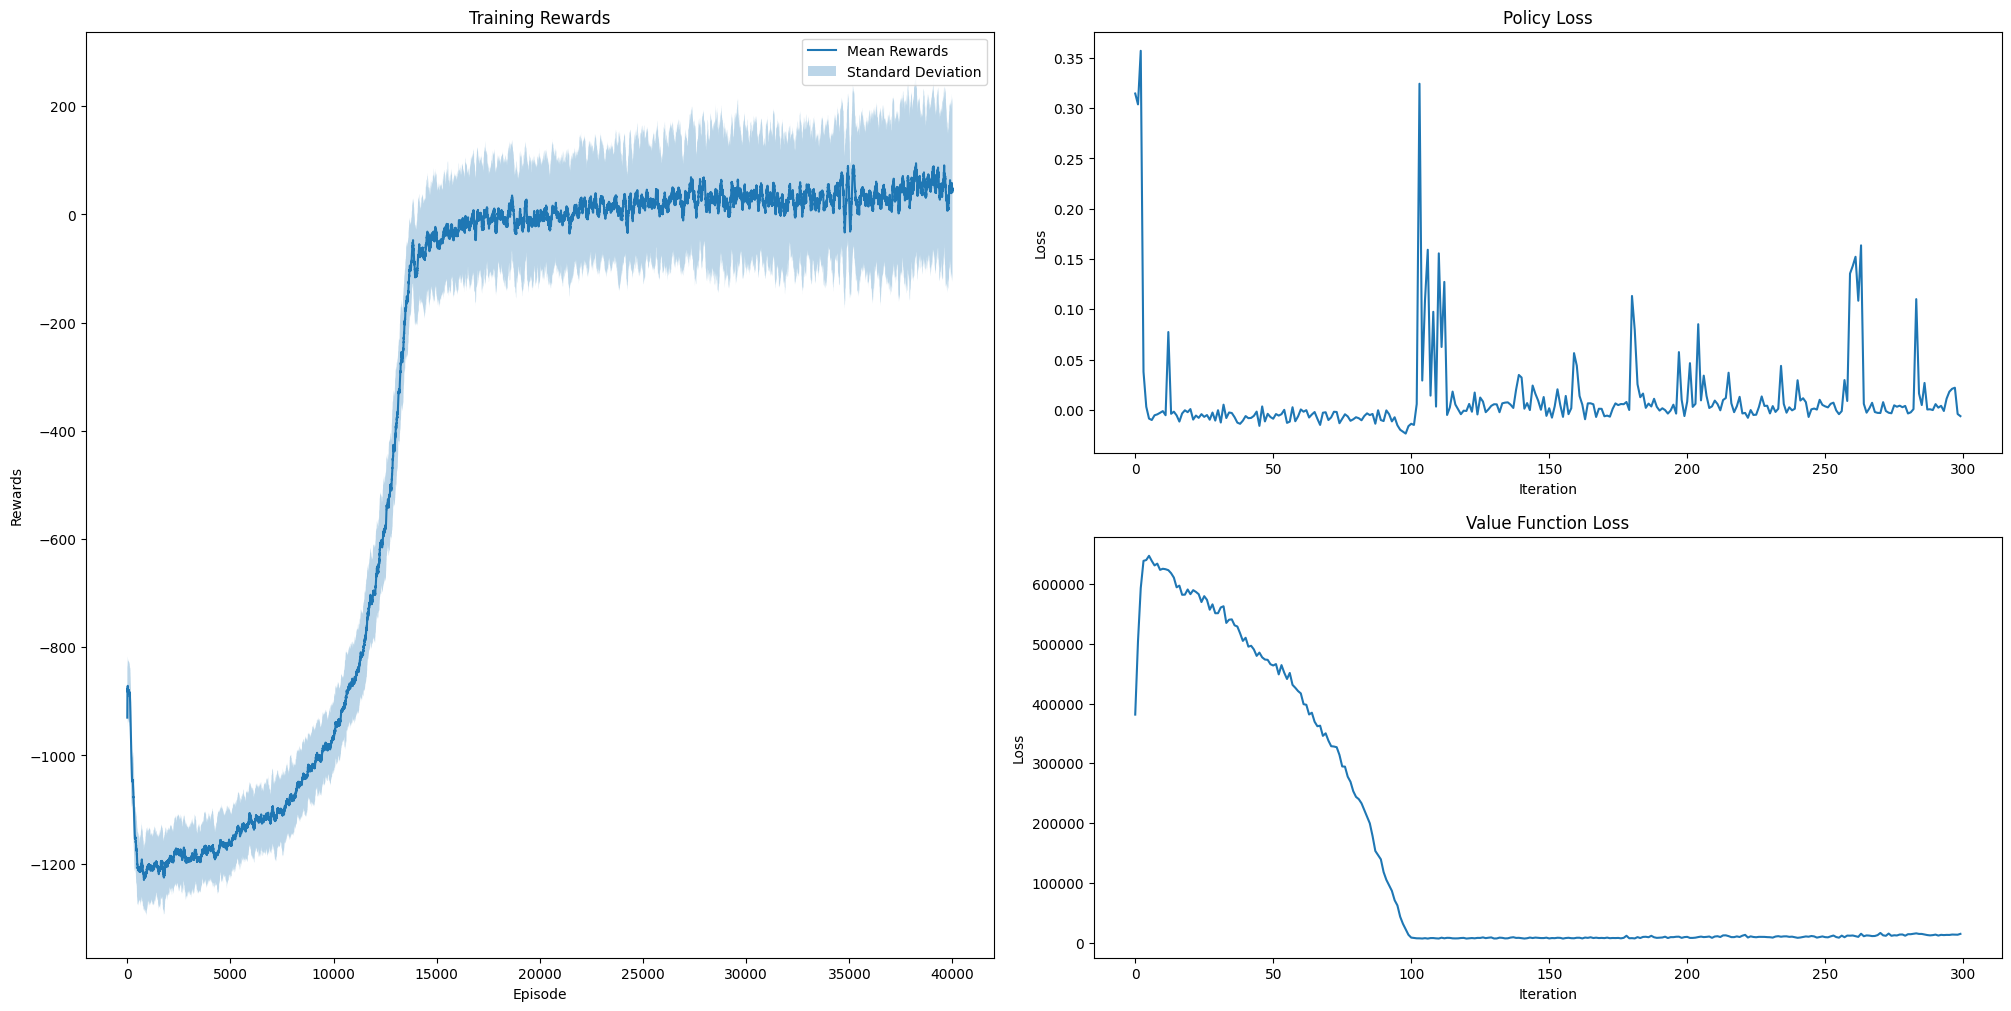

2025-11-17 06:04:35,070	ERROR worker.py:643 -- Calling ray.init() again after it has already been called.
2025-11-17 06:04:35,094	WARNING catalog.py:369 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2025-11-17 06:04:35,099	WARNING util.py:39 -- Install gputil for GPU system monitoring.
2025-11-17 06:04:35,137	INFO trainable.py:481 -- Restored on 192.168.2.116 from checkpoint: C:\Users\24608/ray_results\PPO_NetworkManagement-v0_2025-11-17_01-19-31g1p5xx79\checkpoint_300\checkpoint-300
2025-11-17 06:04:35,138	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 16729.318150758743, '_episodes_total': 40000}



Restoring agent from checkpoint to plot NAM contributions...

Model is on device: cuda:0
Plotting NAM Feature Contributions...


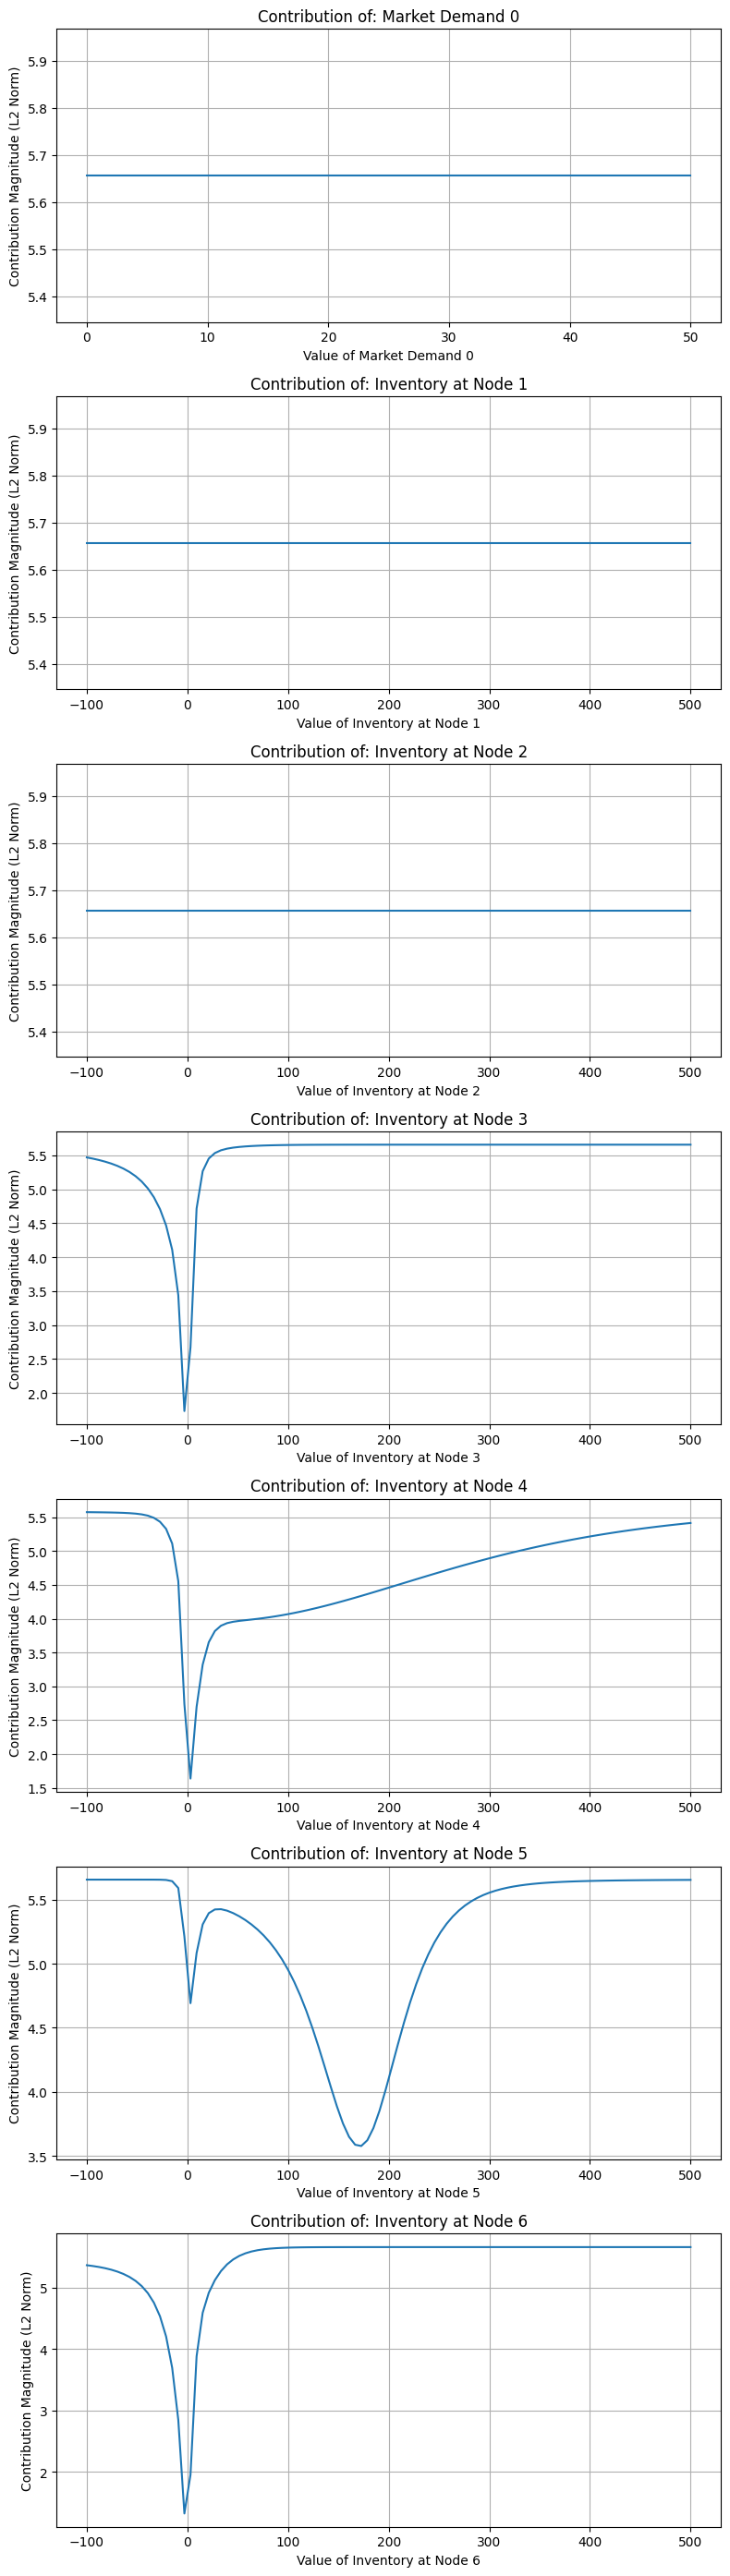

Analysis complete.


In [2]:
training_results, checkpoint = train_agent()

# Plot standard training metrics
plot_training_results(training_results)

# Restore the agent from the checkpoint for analysis
print("\nRestoring agent from checkpoint to plot NAM contributions...")
ray.init(ignore_reinit_error=True)
agent_for_analysis = PPOTrainer(config=rl_config, env=env_name)
agent_for_analysis.restore(checkpoint)

# Plot the NAM interpretability graphs
plot_nam_feature_contributions(agent_for_analysis, feature_names)

ray.shutdown()
print("Analysis complete.")